# Project 2: Segmentation

### What to Submit
Submit this iPython Notebook--containing all your code for the programming exercises below--on [learning suite](https://learningsuite.byu.edu/).

Your notebook file should produce the relevant plots and also provide a short write-up with answers to the questions below.

Please also fill in here the time that each part took you:
* 1. Setting up PyMaxFlow: <span style="color:red;">15 min</span>
* 2. Getting your first successful segmentation: <span style="color:red;">3 hours</span>
* 3. Adjusting parameters (e.g. $\lambda$, $\sigma$) and so forth, to get good results: <span style="color:red;">3 hours</span>
* 4. Completing the write-up: <span style="color:red;">15 min</span>

Note that there are two folders within the project.  We have provided some images for you to use in testing your implementation, in the `provided images` folder along with their ground-truth segmentations to compare your results to.  Along with these, we want you to provide 2-4 additional images that you select on which you show your results.  <i>Please use the `provided_images` in that path and place any others in the `user_data` folder, and load all of the images (or user input point location files) via the approapriate relative path.  We will drop your notebook file and your `user_data` folder into our folder (which will have the `provided_images` already) and then run your notebook.</i>




## Preparation:
So that you can focus on the elements of the cost function ( the link weights), you may use a existing implementation of the actual min-cut algorithm itself.  You set up the graph, but it will take care of finding the minimum cut.

For this assignment we will be using a python library called PyMaxFlow.  This library is a python wrapper around the original C++ implementation of the min-cut code from [Vladimir Kolmogorov](http://pub.ist.ac.at/%7Evnk/software.html) (who has co-authored several papers on this subject).    

Note: For windows users, you will need the Visual C++ compiler in order for PyMaxFlow to work.  If you already have Visual Studio, this shouldn't be a problem but if you just want the compiler without Visual Studio, you can download [Build Tools For Visual Studio 2017](https://visualstudio.microsoft.com/downloads/#build-tools-for-visual-studio-2017). Once you have access to the Visual C++ compiler look at the next paragraph for PyMaxFlow installation.

PyMaxFlow requires Cython, which should come standard in your anaconda environment but the command to install that will also be included.  To install PyMaxFlow enter the following commands replacing "YourEnvironmentName" with the name of your anaconda environment.
~~~
conda activate YourEnvironemntName
conda install cython
pip install pymaxflow
~~~
Once PyMaxFlow is installed, to understand how to use the library, there is a great [tutorial page](http://pmneila.github.io/PyMaxflow/tutorial.html) that shows how to get started with some simple examples.  Do the "first example" and perhaps the "binary image restoration" as well.



## Annotations:
Graph cut segmentation is an interactive algorithm requiring the user to provide foreground and background seeds.  Provided is a python file that will open a gui and allow you to annotate the image.  This gui is optional and will require additional packages to be installed into your environment.  To install the packages open a terminal and enter the following commands:
~~~
conda activate YourEnvironmentName
conda install scikit-image pillow
~~~
You can use the gui in the following way:
```python
import guiseg
fore, back = guiseg.get_fore_back(image)
image[fore]  # the foreground seeds
image[back]  # the background seeds
```

For the `guiseg` routine to run, I also found it necssary to install PIL ImageTk (For me, it was `sudo apt install python3-pil.imagetk` but it will be different for Conda).

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
import guiseg
from sklearn.neighbors import KernelDensity
import cv2
import maxflow
import numpy as np
import matplotlib.pyplot as plt # this is so that you can see which functions come from the pyplot library
plt.rcParams['figure.figsize'] = [20,20]
plt.rcParams['axes.titlesize'] = '16'
plt.rcParams['axes.titleweight'] = 'bold'

def just_title(title):
    a = plt.gca()
    a.set_title(title, fontdict={'fontsize': rcParams['axes.titlesize'],
                                 'fontweight' : rcParams['axes.titleweight'],
                                 'verticalalignment': 'baseline',
                                 'horizontalalignment': 'center'})
    a.set_xticks([])
    a.set_yticks([])

In [5]:
## Provided Images #################################################
banana = cv2.imread('provided_images/banana.png')[:,:,::-1]
# b_fore, b_back = guiseg.get_fore_back(banana)
# np.save("user_data/banana-fore", b_fore)
# np.save("user_data/banana-back", b_back)
b_fore = tuple(np.load("user_data/banana-fore.npy"))
b_back = tuple(np.load("user_data/banana-back.npy"))


penguin = cv2.imread('provided_images/penguin.png')[:,:,::-1]
# p_fore, p_back = guiseg.get_fore_back(penguin)
# np.save("user_data/penguin-fore", p_fore)
# np.save("user_data/penguin-back", p_back)
p_fore = tuple(np.load("user_data/penguin-fore.npy"))
p_back = tuple(np.load("user_data/penguin-back.npy"))


llama = cv2.imread('provided_images/llama.jpg')[:,:,::-1]
# l_fore, l_back = guiseg.get_fore_back(llama)
# np.save("user_data/llama-fore", l_fore)
# np.save("user_data/llama-back", l_back)
l_fore = tuple(np.load("user_data/llama-fore.npy"))
l_back = tuple(np.load("user_data/llama-back.npy"))


teddy = cv2.imread('provided_images/teddy.png')[:,:,::-1]
# t_fore, t_back = guiseg.get_fore_back(teddy)
# np.save("user_data/teddy-fore", t_fore)
# np.save("user_data/teddy-back", t_back)
t_fore = tuple(np.load("user_data/teddy-fore.npy"))
t_back = tuple(np.load("user_data/teddy-back.npy"))


In [6]:
# ## User Images ##################################################
# hawk = cv2.imread('user_data/hawk.jpg')[:,:,::-1]
# # h_fore, h_back = guiseg.get_fore_back(hawk)
# # np.save("user_data/hawk-fore", h_fore)
# # np.save("user_data/hawk-back", h_back)
# h_fore = tuple(np.load("user_data/hawk-fore.npy"))
# h_back = tuple(np.load("user_data/hawk-back.npy"))


# pancakes = cv2.imread('user_data/pancakes.jpg')[:,:,::-1]
# # pan_fore, pan_back = guiseg.get_fore_back(pancakes)
# # np.save("user_data/pancakes-fore", pan_fore)
# # np.save("user_data/pancakes-back", pan_back)
# pan_fore = tuple(np.load("user_data/pancakes-fore.npy"))
# pan_back = tuple(np.load("user_data/pancakes-back.npy"))


# whale = cv2.imread('user_data/whale.jpg')[:,:,::-1]
# # w_fore, w_back = guiseg.get_fore_back(whale)
# # np.save("user_data/whale-fore", w_fore)
# # np.save("user_data/whale-back", w_back)
# w_fore = tuple(np.load("user_data/whale-fore.npy"))
# w_back = tuple(np.load("user_data/whale-back.npy"))



## Graph Cut:
Your code should read in an image and a set of seed pixels and use graph-cut segmentation to segment the image.

You will need to calculate the costs for the t-links (region terms) and the n-links (boundary terms). See the book, the notes/slides, or published papers in this area for ideas of how to define these.  Remember that the t-link weights to a particular terminal (foreground or background) should be large if that pixel looks a lot like the respective foreground/background seeds. The n-link weights should be large if the two neighboring pixels are similar.

Here is [the original paper on graph-cut segmentation](http://www.csd.uwo.ca/~yuri/Papers/iccv01.pdf), which might help with some ideas, but you should look at the literature to see what other costs functions / link weights others have used.

Once the graph is built, use the min-cut algorithm to partition the graph into nodes connected to the foreground node or to the background node, then use these as the resulting labels for the segmentation. Display this result graphically in some fashion overlaid on the input image.  It is best to start with simple images whose foreground and background colors are pretty different and for ones where the edges are pretty clear.  Graph-cut segmentation struggles sometimes with long, thin structures, so you should avoid these types of images early on.



In [7]:
# Implementation Here (feel free to add additional cells of course)

# Create the graph and nodes
def graph_cut(input, fore, back, sigma=8, bandwidth_=1.0, lambda_ = 1):
    # Create the graph ###################################################
    g = maxflow.Graph[int]()
    image = input.copy()
    dimensions = (image.shape[0], image.shape[1])
    nodeids = g.add_grid_nodes(dimensions)

    # Add the n-links (Boundary)##################################################################

    # get the left right edges
    A_image = image[:,:-1]     # left
    B_image = image[:,1:]      # right
    lr_diff = A_image - B_image
    lr_weights = [np.power(np.e, -np.linalg.norm(pixel)/(2*sigma**2)) for row in lr_diff for pixel in row]
    lr_weights = np.resize(np.array(lr_weights), dimensions)
    # get the top bottom edges
    C_image = image[:-1,:]    # top
    D_image = image[1:,:]     # bottom
    tb_diff = C_image - D_image

    tb_weights = [np.power(np.e, -np.linalg.norm(pixel)/(2*sigma**2)) for row in tb_diff for pixel in row]
    tb_weights = np.resize(np.array(tb_weights), dimensions)
    
    # add the n-links to the graph
    g.add_grid_edges(nodeids, lr_weights, structure=[[0,0,0],[0,0,1],[0,0,0]], symmetric=True)
    g.add_grid_edges(nodeids, tb_weights, structure=[[0,0,0],[0,0,0],[0,1,0]], symmetric=True)

    
    # Add the t-links ##################################################

    # Create the KDEs
    kde_source = KernelDensity(kernel='gaussian', bandwidth=bandwidth_).fit(image[fore])
    kde_sink = KernelDensity(kernel='gaussian', bandwidth=bandwidth_).fit(image[back])

    log_density_source = kde_source.score_samples(np.reshape(image, (image.shape[0]*image.shape[1], 3)))
    log_density_sink = kde_sink.score_samples(np.reshape(image, (image.shape[0]*image.shape[1], 3)))

    log_density_source = np.reshape(log_density_source, dimensions) * lambda_
    log_density_sink = np.reshape(log_density_sink, dimensions) * lambda_

    # add the terminal edges
    g.add_grid_tedges(nodeids, log_density_source, log_density_sink)

    # Get the final segments #######################################
    g.maxflow()

    final_segmentation = g.get_grid_segments(nodeids)
    final_segmentation = np.invert(final_segmentation)

    return final_segmentation

In [8]:
def get_trimap(dimensions, fore, back):
    trimap = np.ones(dimensions) * 125
    trimap[fore] = 255
    trimap[back] = 0

    return trimap

In [9]:
# banana Results ########################################
# b_seg, b_trimap = graph_cut(banana, b_fore, b_back, sigma=12, bandwidth_=1.0)
# b_ground_truth = cv2.imread('provided_images/ground_truth/banana-seg.png')

TypeError: get_trimap() missing 2 required positional arguments: 'fore' and 'back'

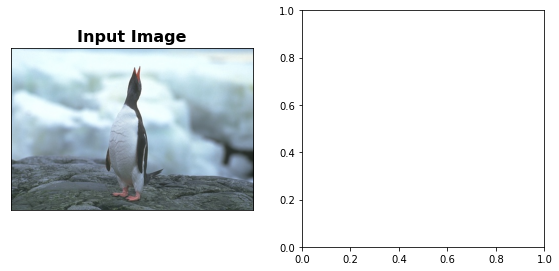

In [10]:
# penguin Results ########################################
p_seg = graph_cut(penguin, p_fore, p_back, sigma=12, bandwidth_=1.5, lambda_=0.5)
p_ground_truth = cv2.imread('provided_images/ground_truth/penguin-seg.png')

plt.subplot(445)
plt.imshow(penguin)
just_title('Input Image')

plt.subplot(446)
plt.imshow(get_trimap((penguin.shape[0], penguin.shape[1], p_fore, p_back)), cmap='gray')
just_title('Trimap')

plt.subplot(447)
plt.imshow(p_seg, cmap='gray')
just_title('Final Segmentation')

plt.subplot(448)
plt.imshow(p_ground_truth)
just_title('Ground Truth')

In [ ]:
# # llama Results ########################################
# l_seg, l_trimap = graph_cut(llama, l_fore, l_back, sigma=12, bandwidth_=1.5)
# l_ground_truth = cv2.imread('provided_images/ground_truth/llama-seg.png')

In [ ]:
# # teddy Results #######################################
# t_seg, t_trimap = graph_cut(teddy, t_fore, t_back,sigma=12)
# t_ground_truth = cv2.imread('provided_images/ground_truth/teddy-seg.png')

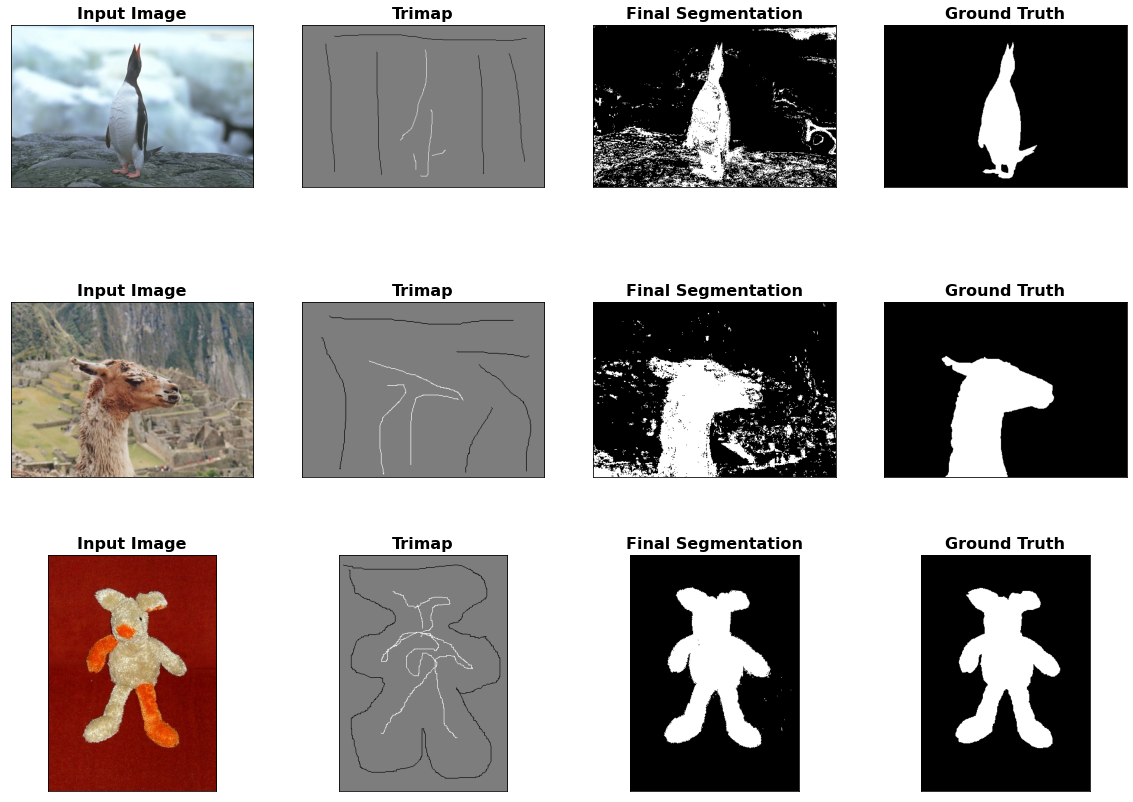

In [ ]:
# #banana ########################################
# # plt.subplot(441)
# # plt.imshow(banana)
# # just_title('Input Image')

# # plt.subplot(442)
# # plt.imshow(b_trimap, cmap='gray')
# # just_title('Trimap')

# # plt.subplot(443)
# # plt.imshow(b_seg, cmap='gray')
# # just_title('Final Segmentation')

# # plt.subplot(444)
# # plt.imshow(b_ground_truth)
# # just_title('Ground Truth')

# #penguin ########################################
# plt.subplot(445)
# plt.imshow(penguin)
# just_title('Input Image')

# plt.subplot(446)
# plt.imshow(p_trimap, cmap='gray')
# just_title('Trimap')

# plt.subplot(447)
# plt.imshow(p_seg, cmap='gray')
# just_title('Final Segmentation')

# plt.subplot(448)
# plt.imshow(p_ground_truth)
# just_title('Ground Truth')


# #llama ########################################
# plt.subplot(449)
# plt.imshow(llama)
# just_title('Input Image')

# plt.subplot(4,4,10)
# plt.imshow(l_trimap, cmap='gray')
# just_title('Trimap')

# plt.subplot(4,4,11)
# plt.imshow(l_seg, cmap='gray')
# just_title('Final Segmentation')

# plt.subplot(4,4,12)
# plt.imshow(l_ground_truth)
# just_title('Ground Truth')

# #teddy ########################################
# plt.subplot(4,4,13)
# plt.imshow(teddy)
# just_title('Input Image')

# plt.subplot(4,4,14)
# plt.imshow(t_trimap, cmap='gray')
# just_title('Trimap')

# plt.subplot(4,4,15)
# plt.imshow(t_seg, cmap='gray')
# just_title('Final Segmentation')

# plt.subplot(4,4,16)
# plt.imshow(t_ground_truth)
# just_title('Ground Truth')

In [ ]:
# # hawk Results ########################################
# h_seg, h_trimap = graph_cut(hawk, h_fore, h_back)

In [ ]:
# whale Results ########################################
# Takes about 6 minutes
# w_seg, w_trimap = graph_cut(whale, w_fore, w_back,sigma=14)

In [ ]:
# # pancakes Results ########################################
# pan_seg, pan_trimap = graph_cut(pancakes, pan_fore, pan_back,sigma=11, bandwidth_=1.5)

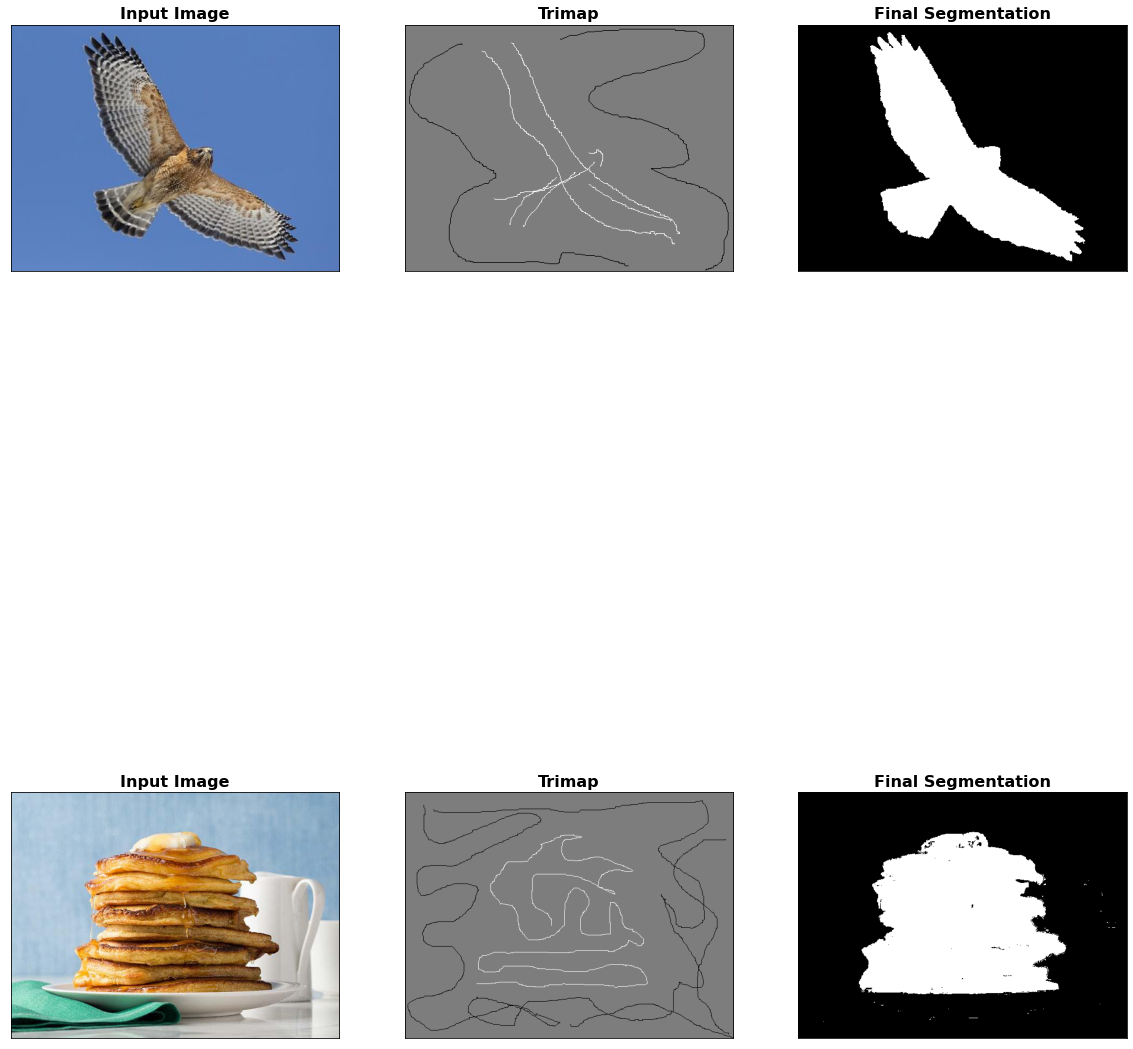

In [ ]:
# #hawk ########################################
# plt.subplot(331)
# plt.imshow(hawk)
# just_title('Input Image')

# plt.subplot(332)
# plt.imshow(h_trimap, cmap='gray')
# just_title('Trimap')

# plt.subplot(333)
# plt.imshow(h_seg, cmap='gray')
# just_title('Final Segmentation')

# #whale ########################################
# # plt.subplot(334)
# # plt.imshow(whale)
# # just_title('Input Image')

# # plt.subplot(335)
# # plt.imshow(w_trimap, cmap='gray')
# # just_title('Trimap')

# # plt.subplot(336)
# # plt.imshow(w_seg, cmap='gray')
# # just_title('Final Segmentation')

# #llama ########################################
# plt.subplot(337)
# plt.imshow(pancakes)
# just_title('Input Image')

# plt.subplot(338)
# plt.imshow(pan_trimap, cmap='gray')
# just_title('Trimap')

# plt.subplot(339)
# plt.imshow(pan_seg, cmap='gray')
# just_title('Final Segmentation')


## Grading / Rubric
Points for this assigment will be assigned as follows (100 points total):
* [20 pts] Code that correctly generates the graph network structure (nodes, n-links, t-links).
* [10 pts] Code that produces the boundary term $B(p,q)$ used for n-links.
* [10 pts] Code that produces the region term of the cost $R(p,A)$ used for the t-links.  Remember that you have t-links per pixel, one with cost determined by matching $p$ with the foreground appearance distribution, the other determined relative to the background distribution.  You may use the [sk-learn implementation](https://scikit-learn.org/stable/modules/density.html#kernel-density-estimation) of Kernel Density Estimation.  However you will receive 10 extra points if you implement it yourself.
* [20 pts] Implementing the graph-cut with `pymaxflow` and finding the optimal solution for the input graph.
* [10 pts] Displaying Results in the following format (for each input image you'll show the following 3-4 result images):
   1. Original Image.
   2. Tri-map of what was selected by the user (white for foreground, black for background, gray for unknown).  This can be overlaid on top of a faint copy of the image for context if desired.
   3. Final segmentation.  Again you can overlay it on a faint copy of the original for context.
   4. On the <i>provided images</i> please show a comparison of your resulting segmentaiton with the ground truth.
* [20 pts] Good (certainly not perfect, some of them are challenging, but decent/reasonable) results on the 4 provided images (banana, llama, penguin, teddy).  Each image will receive up to 5 points.
* [10 pts] Demonstrating your algorithm on 2-4 additional images.  At least one of the images should be somewhat easy, one should be somewhat challenging -- expalin why you think they're respectively easy/challenging.


## Write-up:
Provide an explanation for the following items:
* Describe how you determinied/computed the n-link and t-link weights.
* What kinds of image does graph cut segmentation work well for? What kinds of images do you find it struggles with?
* What did you learn from the project?
* What if any suggestions do you have for improving it (for future students)?

I found the n-links by having two matrices that were offset derived from the original image. I took the difference of these to find the boundary weights of the left to right and top to bottom edges. 
For the t-links I used skilearn.KDE to calculate the t-links for the source and sink separately.

Graph cut segmentation definitely worked better on images with high contrast and fewer colors. When there were many colors or similar colors it had a hard time getting a good segmentation result. The whale image for example has a lot of similar colors with the water droplets coming over the whale. I used a lot of sample pixels and it takes about 6 minutes to calculate the segmentation. There is still a lot of noise in the final image even with the careful setup.

I learned that good segmentation is difficult. It requires careful selection of images, preparation of the image, and fine tuning of parameters. 

I would suggest that the seed pixels are given. I liked the GUI and it was fun to see how selecting different seed values changed the final image, but it would be nice to be base the final image off of the same seeds and not how well you pick them. But maybe that is part of the skill too.